# Language Models

In this notebook, we build on the concepts that we have learned in the first two sessions of the workshop and develop neural networks for language processing. 

**Learning outcomes:**
1. A conceptual understanding how modern neural networks process language;
2. The use of inductive biases for learning generalisable concepts of language; and
3. An understanding of the limitations of current neural network-based language modelling approaches

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import kai

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 Inductive biases for language

In the previous sessions, we saw that neural networks are incredibly versatile and can be used to solve many complex tasks. We specifically focussed on MLPs and their ability to approximate any function using sufficiently many input-output data points (universal function approximation theorem). However, we also highlighted that MLPs are not good at learning concepts that they can use to generalise beyond the training data. This left us with a mediocre Q&A neural network which was limited to answering a pre-defined set of questions. To improve the generalisability of neural networks, we discussed inductive biases and the role of prior knowledge to enable more efficient training. In this session, we can finally begin to model language!

One of the challenges with our Q&A neural network was that our model didn't really have a sense of language -- we simply mapped question IDs to answer IDs. So, perhaps, one way to approach Q&A is to take a step back and to just focus on the language component of the task for the moment. In other words, we remove the requirement that the neural network needs to retain knowledge and are simply left with building a model that can produce grammatically correct sentences. Such a neural network is more useful than you might think and, in fact, most of us have probably a device with such a neural network in our pockets right now -- the text auto-completion functionality of the keyboards in our phones!

### Task 1: Discuss which inductive biases could be useful for text auto-completion?

Inductive biases, such as translational invariance, seem quite intuitive for image classification. But what are useful inductive biases for language?

*Hint 1:* Remember that last time, we had a problem to generalise our Q&A MLP model because we enumerated complete questions and complete answers. This time, think, perhaps, a little bit more granular. What if we enumerate words, or even letters. Is there an inductive <*blank*> that we can use to help with the language processing?

You can document your thoughts here:

Text auto-completion can be phrased as a next-word prediction task, where we use preceeding words to inform our prediction for the next word. So one element of our prior knowledge for text completion is that it viewed as an iterative task where we use preceeding words to make a prediction; use the preceeding words and our prediction for the next predictions; use the preceeding words and predictions for the next predictions, and so on. We can use this to define a *recurrent* neural network architecture that can predict the next words iteratively based on the previous words (see below).

<img src="example.gif" width="700" style="display: block; margin: 0 auto" >

Another element of our prior knowledge is that on a very superficial level, next word prediction can be seen as a statistical problem: In the above example in *Hint 1*, all of you knew that the missing word was *bias*. Why? Well, probably because our brains made a statistical inference: "bias" was the only word in this entire workshop that ever followed the word "inductive".  

But how many preceeding words do we need to make good predictions? For the "inductive <*blank*>" example, one preceding word is sufficient to be pretty confident that the next word is "bias". But what about other <*blank*>? Now it is less clear what the missing word is! It could be "words", it could be "examples", or it could be "instances", or it could be something completely different. This shows that by only looking at one preceeding word there is a certain level of ambuiguity in language.

This ambiguity can be resolved (to some degree) by looking at more than just one word. For example by looking at the entire preceeding sentence "For the "inductive <*blank*>" example, one preceding word is sufficient to be pretty confident that the next word is "bias".", it may be more obvious that the most likely word is "words", while "examples" might also work for the sentence. Other words seem less likely.

This illustrates that text auto-completion is context-dependent. The information provided by the previous words influences the likelihood of the next word! To get a feeling for how many words are needed to make relatively confident next word predictions, let us analyse an example text: Shakespeare's A Midsummer Night's Dream, and let us, for simplicity, focus on letters intead of on words. We can determine the level of ambiguity of the next-letter prediction by counting how many different letters occur following a given sequence of letters.

### Task 2: Empirically determine a useful context-size

Below is the dataset which contains the text from Shakespeare's A Midsummer Night's Dream. Count how many different letters follow the following (arbitrarily chosen) sequences:

1. l
2. lov
3. love ca

In [2]:
# Visualise dataset
text = kai.get_midsummer_night_dream()

# Shows a short text sample
print(text[:420])

A Midsummer Night's Dream
by William Shakespeare

ACT 1
=====

Scene 1
[Enter Theseus, Hippolyta, and Philostrate, with others.]


THESEUS
Now, fair Hippolyta, our nuptial hour
Draws on apace. Four happy days bring in
Another moon. But, O, methinks how slow
This old moon wanes! She lingers my desires
Like to a stepdame or a dowager
Long withering out a young man's revenue.

HIPPOLYTA
Four days will quickly st


In [12]:
# TODO: Find how many different letters follow the below patterns
# NOTE: You can just append each letter that follows the patterns to corresponding "bins".
# You can then use the cell below to visualise the counts
pattern1 = 'l'
pattern2 = 'lov'
pattern3 = 'love c'
bin1 = []
bin2 = []
bin3 = []

text = text.lower()
# TODO: Find all the letters following the patterns
for idl in range(len(text)):
    if pattern1 in text[idl]:
        bin1.append(text[idl+1])
    window = len(pattern2)
    if pattern2 in text[idl:idl+window]:
        bin2.append(text[idl+window+1])
    window = len(pattern3)
    if pattern3 in text[idl:idl+window]:
        bin3.append(text[idl+window+1])


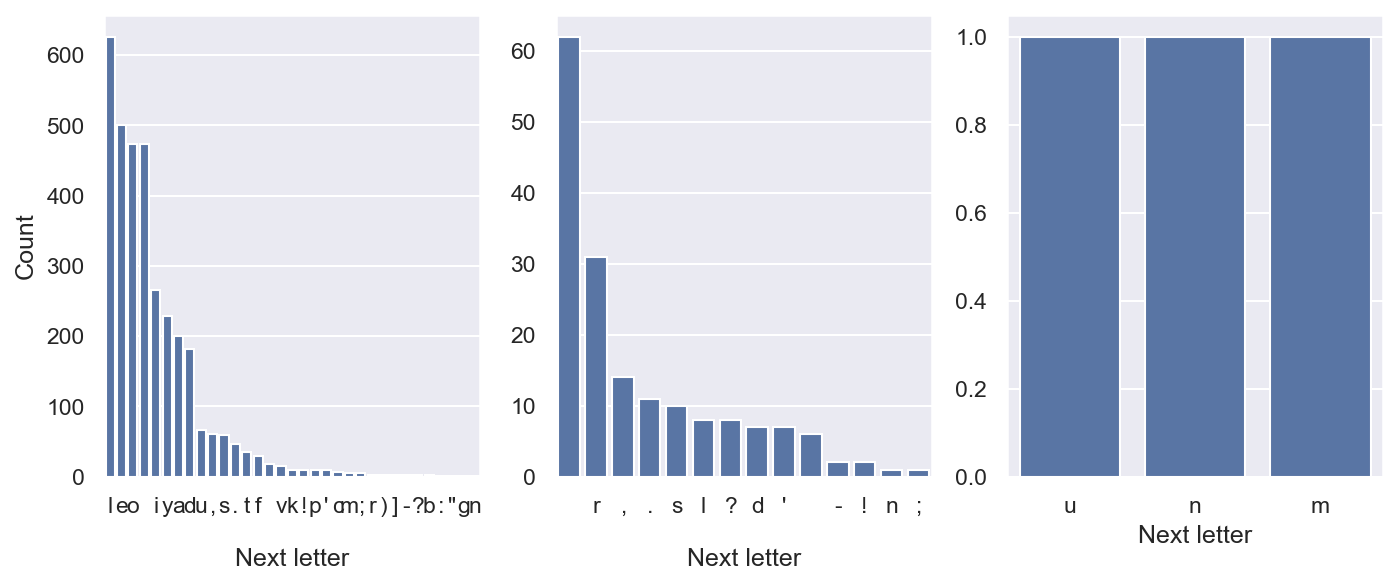

In [4]:
# Visualise count
kai.plot_letter_count(bin1, bin2, bin3)

Ok! We can see that the more letters we keep track of, the less ambiguity there is with regard to the next letter, and by keeping track of 5 letters (including the space symbol as a letter), we are down to three options for the sequence "love c". This suggests that a relatively short context size of around 5 letters could perhaps be enough to make quite confident next letter predictions!

Note that if we can predict the next letter, we can also predict next words! By simply including predictions as context for the next prediction. This is illustrated in the figure below for next word prediction (because we couldn't find a similar gif for letter prediction).

<img src="next-word-pred.gif" width="700" style="display: block; margin: 0 auto" >

### Task 3: Define a vocabulary for your language model

Now it's time to implement our first language model! The first component of any language model is to define the inputs and outputs. So we need to transate words or letters into numerical values. These numerical values are typically referred to as *tokens*. Here, we want to keep it simple and therefore just enumerate all unique characters that appear in Shakespeare's text. 

*Aside:* Modern language model's use more complex "tokenisers" which take more prior knowledge about a language into account (for example it can make sentence to have one token for the stem of a word and several tokens for the different conjugations).

In [5]:
# TODO: Execute the below cell to define the vocabulary for our language model
class Vocabulary():
    def __init__(self, text):
        unique_letters = np.unique(list(text))
        self.letter2index = {letter: idx for idx, letter in enumerate(unique_letters)}
        self.index2letter = {idx: letter for idx, letter in enumerate(unique_letters)}

    def get_letters(self, indices):
        out = []
        for idx in indices:
            out.append(self.index2letter[idx])

        return out

    def get_indices(self, letters):
        out = []
        for letter in letters:
            out.append(self.letter2index[letter])

        return out

# Example
vocab = Vocabulary(text=text)
print(f'Letters: {text[:20]}')
print(f'Indices: {vocab.get_indices(text[:20])}')
print(f'Letters: {vocab.get_letters(vocab.get_indices(text[:20]))}')

Letters: a midsummer night's 
Indices: [22, 2, 34, 30, 25, 40, 42, 34, 34, 26, 39, 2, 35, 30, 28, 29, 41, 5, 40, 2]
Letters: ['a', ' ', 'm', 'i', 'd', 's', 'u', 'm', 'm', 'e', 'r', ' ', 'n', 'i', 'g', 'h', 't', "'", 's', ' ']


### Task 4: Define a MLP that takes in 5 tokens (letter IDs) and predicts the probability masses over the vocabulary

The 10 input tokens is the window size of the language model and the output probability masses are the predictions of the model for the next letter.

In [7]:
# TODO: Define the MLP
class MLP(nn.Module):
    def __init__(self, context_size=5, output_size=48):
        super(MLP, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(context_size, 128, dtype=float),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=float),
            nn.ReLU(),
            nn.Linear(64, output_size, dtype=float),
        )

    def forward(self,x):
        out = self.classifier(x)
        return out

### Task 5: Train the language model on A Midsummers Night's Dream

For simplicity, we have already prepared a DataLoader that splits Shakespeare's play into a training and test set and also parses the text into batches of 10 tokens with subsequent 11th token that needs to be predicted.

Got 6851/892288 with accuracy  0.77
Epoch: 0
Got 218178/892288 with accuracy  24.45
Epoch: 1
Got 230347/892288 with accuracy  25.82
Epoch: 2
Got 239457/892288 with accuracy  26.84
Epoch: 3
Got 245599/892288 with accuracy  27.52
Epoch: 4
Got 252596/892288 with accuracy  28.31
Epoch: 5
Got 259665/892288 with accuracy  29.10
Epoch: 6
Got 267876/892288 with accuracy  30.02
Epoch: 7
Got 267400/892288 with accuracy  29.97
Epoch: 8
Got 270512/892288 with accuracy  30.32
Epoch: 9
Got 280425/892288 with accuracy  31.43
Epoch: 10
Got 278756/892288 with accuracy  31.24
Epoch: 11
Got 286988/892288 with accuracy  32.16
Epoch: 12
Got 288175/892288 with accuracy  32.30
Epoch: 13
Got 288723/892288 with accuracy  32.36
Epoch: 14
Got 293610/892288 with accuracy  32.91
Epoch: 15
Got 297323/892288 with accuracy  33.32
Epoch: 16
Got 298475/892288 with accuracy  33.45
Epoch: 17
Got 298519/892288 with accuracy  33.46
Epoch: 18
Got 302539/892288 with accuracy  33.91
Epoch: 19
Got 304817/892288 with accuracy  

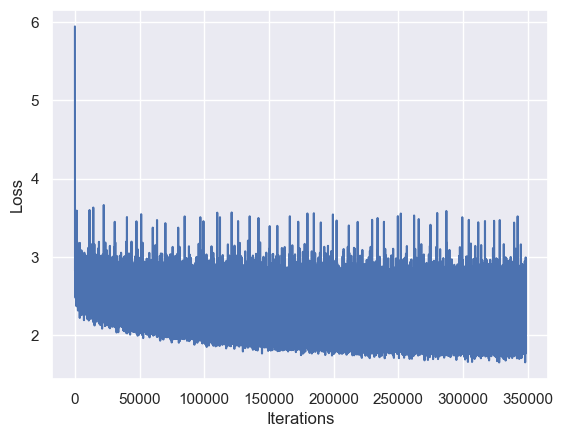

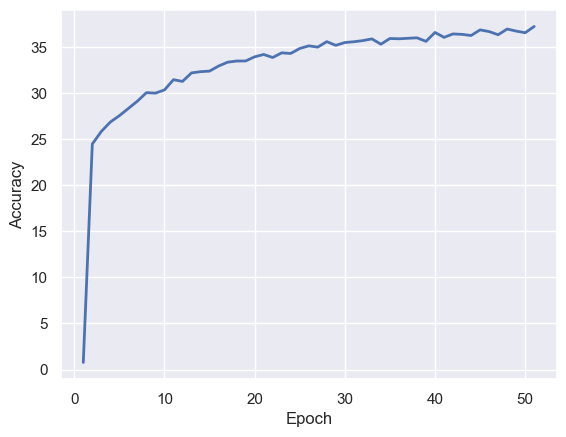

In [9]:
# Load data
context_size = 5
trainloader, testloader = kai.get_shakespeare_dataloader(
    window_size=context_size, batch_size=128)

# Train Network
learning_rate = 0.0005
num_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(context_size=context_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
accuracy = []
accuracy.append(kai.check_accuracy_language(trainloader, model, device))
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(trainloader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()
        losses.append(loss.detach().numpy())

    accuracy.append(kai.check_accuracy_language(trainloader, model, device))

kai.plot_loss(losses)
kai.plot_accuracy(accuracy)

Ok, the accuracy of our language model is not great but also not too bad given that we only consider 5 preceeding letters and we didn't train the model for very long. Let us see how well the model performs when we try to complete a word!

### Task 6: Auto-complete the below text examples

predict next letters until a space (``' '``), tab (``'\t'``) or new line (``'\n'``) is predicted. Use the above defined vocabulary to convert between letters and tokens.

In [15]:
def auto_complete(text, model):
    # Stop tokens
    stop_tokens = vocab.get_indices([' ', '\t', '\n'])

    # Complete sentences with model
    context = vocab.get_indices(text)
    out = ''
    with torch.no_grad():
        while out not in stop_tokens:
            # Prepare input
            c = np.array(context[-context_size:], dtype=float)
            input = torch.tensor(c).reshape(1, context_size)

            # Make prediction
            output = model(input)
            out = output.max(1)[1].detach().numpy()[0]

            # Append to solution
            context.append(out)

    return context

In [21]:
# TODO: Auto-complete the words
# 1
test = 'love c'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 2
test = 'digni'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 3
test = 'waggi'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 4
test = 'intelligenc'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

Start:  love c
Auto-complete:  love c;

Start:  digni
Auto-complete:  digni

Start:  waggi
Auto-complete:  waggi;

Start:  intelligenc
Auto-complete:  intelligenc:i



Ok... this is not working at all!

### Task 6: Discuss why the accuracy of model is relatively high but the predictions make no sense?

*Hint:* The bad predictions are not related to model architecture or the number of training epochs.

Got 498/892288 with accuracy  0.06
Epoch: 0
Got 96643/892288 with accuracy  10.83
Epoch: 1
Got 100997/892288 with accuracy  11.32
Epoch: 2
Got 103644/892288 with accuracy  11.62
Epoch: 3
Got 108515/892288 with accuracy  12.16
Epoch: 4
Got 104764/892288 with accuracy  11.74
Epoch: 5
Got 106746/892288 with accuracy  11.96
Epoch: 6
Got 110629/892288 with accuracy  12.40
Epoch: 7
Got 111659/892288 with accuracy  12.51
Epoch: 8
Got 112882/892288 with accuracy  12.65
Epoch: 9
Got 109989/892288 with accuracy  12.33
Epoch: 10
Got 111686/892288 with accuracy  12.52
Epoch: 11
Got 115379/892288 with accuracy  12.93
Epoch: 12
Got 114041/892288 with accuracy  12.78
Epoch: 13
Got 113593/892288 with accuracy  12.73
Epoch: 14
Got 117284/892288 with accuracy  13.14
Epoch: 15
Got 115485/892288 with accuracy  12.94
Epoch: 16
Got 116951/892288 with accuracy  13.11
Epoch: 17
Got 115899/892288 with accuracy  12.99
Epoch: 18
Got 119482/892288 with accuracy  13.39
Epoch: 19
Got 119604/892288 with accuracy  13

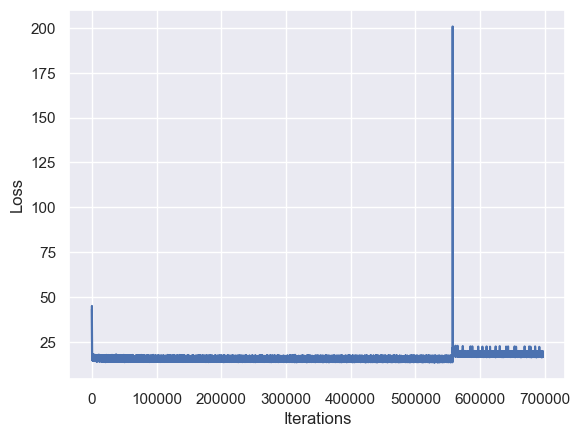

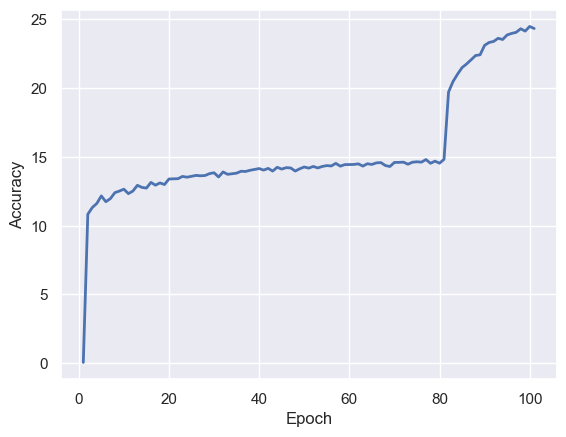

In [63]:
# Load data
context_size = 5
n_sequential = 5
trainloader2, _ = kai.get_shakespeare_dataloader(
    window_size=context_size+n_sequential, batch_size=128)

# Train Network
learning_rate = 0.0001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(context_size=context_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
accuracy = []
accuracy.append(kai.check_accuracy_language(trainloader, model, device))
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(trainloader2):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # TODO: Predict the next token sequentially
        context = data.clone()[:, :context_size]
        loss = 0
        for idx in range(n_sequential):
            scores = model(context)

            if epoch < 0.8 * num_epochs:
                # Mask non alphabetic predictions
                mask = data[:, context_size+idx] > 21
            else:
                # Do not mask anything
                mask = data[:, context_size+idx] >= 0

            loss += criterion(
                scores[mask], data[mask, context_size+idx].to(dtype=int))

            pred = scores.max(1)[1]
            pred = pred.reshape(len(pred), 1)

            # Update context
            context = torch.concat((context[:, 1:], pred), dim=1)

        # Rescale to counter class imbalance
        loss += criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()
        losses.append(loss.detach().numpy())

    accuracy.append(kai.check_accuracy_language(trainloader, model, device))

kai.plot_loss(losses)
kai.plot_accuracy(accuracy)

In [64]:
# TODO: Auto-complete the words
# 1
test = 'love c'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 2
test = 'digni'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 3
test = 'waggi'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

# 4
test = 'intelligenc'
print('Start: ', test)
prediction = auto_complete(test, model)
prediction = vocab.get_letters(prediction)
print('Auto-complete: ', ''.join(prediction))

Start:  love c
Auto-complete:  love cf

Start:  digni
Auto-complete:  digni

Start:  waggi
Auto-complete:  waggi;

Start:  intelligenc
Auto-complete:  intelligenc



# 2 Getting the Data

Our goal is to create a model that generates Shakespearian sonnets. 
One of the easiest ways to do this is to give the model some Shakespearian text and get it to predict the next letter.
For example, if we give the model "to be or not to b", it can output "e" to complete the phrase - "to be or not to be".
Then, if we give that output to the model as input, the model can give us the next character, and so on.
We might not get "to be or not to be, that is the question." as the final output, but we can get something that sounds vaguely Shakespearian.

But first, we need to get the data!

In [1]:
import tensorflow as tf

# Download the Shakespeare dataset
shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

# Shows a short text sample
print(shakespeare_text[:420])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!


That's Shakespeare, alright! 

The input to our model will be a the beginning of a Shakespeare sonnet (i.e. a sequence of characters).
Given this sequence of characters, we want our model to predict the next character.
For simplicity, we will only use **lowercase** characters.

In [2]:
vocab = "".join(sorted(set(shakespeare_text.lower())))
vocab_size = len(set(shakespeare_text.lower()))

print("Our vocabulary: " + vocab)
print("Number of distinct characters: " + str(vocab_size))

Our vocabulary: 
 !$&',-.3:;?abcdefghijklmnopqrstuvwxyz
Number of distinct characters: 39


# 3 Creating the Training Dataset

The inputs to a neural network must be numerical, so we must encode every character as an integer.

It's easiest to do this using `keras.layers.TextVectorization` layer to encode this text (i.e. convert it from characters to integer IDs).
This layer turns raw strings into an encoded representation that can be read by neural network layers.
We set `split="character"` to get character-level encoding rather than the default word-level encoding, and we use `standardize="lower"` to convert the text to lowercase.

In [3]:
# Create a TextVectorization layer
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")

# Build a vocabulary of all characters in the Shakespeare text
text_vec_layer.adapt([shakespeare_text])

# Use text_vec_layer on shakespeare_text to obtain encoded character ID sequences
encoded = text_vec_layer([shakespeare_text])[0]

# Visualize the encoding
print("--- Original text:\n", shakespeare_text[:60])
print("\n--- Encoded sequence:\n", encoded[:60])
print("\n--- Mapping of letters to integers:")
for i, char in enumerate(text_vec_layer.get_vocabulary()[:20]):
    print(char, "-->", i)

--- Original text:
 First Citizen:
Before we proceed any further, hear me speak.

--- Encoded sequence:
 tf.Tensor(
[21  7 10  9  4  2 20  7  4  7 37  3 11 25 12 23  3 21  5 10  3  2 18  3
  2 24 10  5 20  3  3 14  2  6 11 17  2 21 15 10  4  8  3 10 19  2  8  3
  6 10  2 16  3  2  9 24  3  6 26 28], shape=(60,), dtype=int64)

--- Mapping of letters to integers:
 --> 0
[UNK] --> 1
  --> 2
e --> 3
t --> 4
o --> 5
a --> 6
i --> 7
h --> 8
s --> 9
r --> 10
n --> 11

 --> 12
l --> 13
d --> 14
u --> 15
m --> 16
y --> 17
w --> 18
, --> 19


Looking at the above output, we can see that each character is now mapped to an integer, starting at 2. 

The `TextVectorization` layer reserved the value 0 for padding tokens, and it reserved 1 for unknown characters.
We won’t need either of these tokens for now because neither are in the vocabulary, so we won't be using them to write our sonnets either.
(When have you seen Shakespeare make up unknown characters? That's why.)

Let’s subtract 2 from the character IDs and compute the number of distinct characters and the total number of characters:

In [4]:
# Drop tokens 0 (pad) and 1 (unknown) by subtracting 2 from the character IDs
encoded -= 2

# Compute the number of distinct characters
n_tokens = text_vec_layer.vocabulary_size() - 2

# Compute the total number of characters
dataset_size = len(encoded)

print("Dataset size: ", dataset_size)
print("Number of tokens: ", n_tokens)

Dataset size:  1115394
Number of tokens:  39


As we've said, our aim is to give the model a sequence of characters (e.g. "to be or not to b"), and get it to output the next letter "e".
We can also frame this as the input being "to be or not to b" being turned into output as "o be or not to be" sequence and target as "o be or not to be" sequence.
This target sequence indicates that for a given input sequence, the next character should be "e".

To train such a sequence-to-sequence RNN, we can convert this long sequence into input/target pairs.
This dataset creation involves dividing the data into windows of a fixed size. 
The model can then be trained on these input/target pairs to learn the underlying patterns in the text and generate more text of a similar style. 

The function `to_dataset` will convert our long sequence of character IDs (encoded text) into a dataset of input/target window pairs.

### Task 2: In the code below, create input/output sequences by taking first `length` characters as input and last `length` characters as output.

In [5]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):

    # Prepare dataset of character IDs to be processed by tensorflow.
    ds = tf.data.Dataset.from_tensor_slices(sequence)

    # Create windows of size length + 1.
    ds = ds.window(size=length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))

    if shuffle:
        ds = ds.shuffle(buffer_size=100_000, seed=seed)

    # Batch the resulting dataset
    ds = ds.batch(batch_size=batch_size)

    # TODO: Create input/output sequences by taking first *length* characters
    # as input and last *length* characters as output.
    # Hint: using the map() method on ds, and use the lambda function to
    # create a tuple with the first length characters as the first element
    # and the last length characters as the second element
    ds = ds.map(lambda window: (window[:, :-1], window[:, 1:]))

    return ds.prefetch(1)

This diagram illustrates what `to_dataset` is doing:

<img src="to_dataset.png" width="500" style="display: block; margin: 0 auto">

Batching is a technique used to divide large datasets into smaller subsets or batches.
Instead of feeding the entire dataset (of our input/output pairs of windows) to the model at once, we divide it into batches, which are fed to the model one-by-one during training.
Each batch is processed independently, and the model updates its weights after processing each batch.
Batching makes training more efficient. 

Let's look an an example of `to_dataset()`. 
The code below creates a dataset with a single training example: an input/output pair.
The input represents "to b" and the output represents "o be", so the model should learn to predict the next character, i.e., "e"

In [6]:
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

Since the entire dataset is 1,115,394 characters long and we have limited time, we will use a smaller portion of the dataset to make sure we can finish training during this workshop.
We will split it up so we use roughly 90% for training, 5% for validation and the remaining 5% for testing.

We initially specified the window length as 100, but it is worth experimenting with different window lengths.
While shorter lengths make it easier and quicker to train the RNN, as the RNN is not able to learn any pattern that is longer than the specified length, it is important to avoid choosing a window length that is too small.

### Task 3: Slice the data into training, validation and test sets using the proportions specified.

In [7]:
length = 100
subset_proportion = 0.05
reduced_dataset_size = int(dataset_size * subset_proportion)

# TODO: Slice the data into training, validation, and test sets using the
# proportions 90%, 5%, 5%
train_encoded = encoded[:int(reduced_dataset_size * 0.9)]
validation_encoded = encoded[int(reduced_dataset_size * 0.9):int(reduced_dataset_size * 0.95)]
test_encoded = encoded[int(reduced_dataset_size * 0.95):reduced_dataset_size]

# Create datasets
tf.random.set_seed(42)
train_set = to_dataset(train_encoded, length=length, shuffle=True, seed=42)
valid_set = to_dataset(validation_encoded, length=length)
test_set = to_dataset(test_encoded, length=length)

# 4 Training Our Own Shakespeare

Since our dataset is reasonably large, and modeling language is quite a difficult task, we need more than a simple RNN with a few recurrent neurons.
Let’s build and train a model with one GRU layer (type of RNN layer) composed of 128 units (you can try tweaking the number of layers and units later, if needed).

Let’s go over this code:

- We use an `Embedding` layer as the first layer, to encode the character IDs (embeddings were introduced in Chapter 13). The `Embedding` layer’s number of input dimensions is the number of distinct character IDs, and the number of output dimensions is a hyperparameter you can tune — we’ll set it to 16 for now. Whereas the inputs of the `Embedding` layer will be 2D tensors of shape *[batch size, window length]*, the output of the Embedding layer will be a 3D tensor of shape *[batch size, window length, embedding size]*.

- We use a `Dense` layer for the output layer: it must have 39 units (n_tokens) because there are 39 distinct characters in the text, and we want to output a probability for each possible character (at each time step). The 39 output probabilities should sum up to 1 at each time step, so we apply the softmax activation function to the outputs of the Dense layer.

- Lastly, we compile this model, using the `"sparse_categorical_crossentropy"` loss and a Nadam optimizer, and we train the model for several epochs, using a `ModelCheckpoint` callback to save the best model (in terms of validation accuracy) as training progresses.

### Task 4: Experiment with different values for epochs
In machine learning, an epoch refers to one iteration of the entire training dataset through a neural network, i.e. one pass forward and backward through the model.
During training, the data is usually divided into batches, and the training process involves iterating through all the batches in one complete iteration.
Increasing the number of epochs will increase the number of times the model gets to refine its weights and improve its predictions on the training set.

In [8]:
# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

# Compile the model, i.e. give it loss function, optimizer and metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

# A callback is a set of functions that can be applied during training to
# perform various tasks, such as saving the best model weights, early stopping
# if the validation loss stops improving, etc.
# Create a ModelCheckpoint callback that saves the best model weights to a file
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="my_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

# Train the model using the fit() method. Pass the training and validation sets
# to the train_set and valid_set parameters, respectively.
# TODO: Choose the number of epochs to train the model for (e.g. 2-5)
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=3,
                    callbacks=[model_ckpt])

Epoch 1/3
   1565/Unknown - 76s 45ms/step - loss: 2.0247 - accuracy: 0.4093INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


1566/1566 [==============================] - 78s 47ms/step - loss: 2.0246 - accuracy: 0.4093 - val_loss: 1.8752 - val_accuracy: 0.4449
Epoch 2/3
1566/1566 [==============================] - 79s 48ms/step - loss: 1.2614 - accuracy: 0.6189 - val_loss: 2.1495 - val_accuracy: 0.4261
Epoch 3/3
1566/1566 [==============================] - 79s 48ms/step - loss: 0.9370 - accuracy: 0.7227 - val_loss: 2.5209 - val_accuracy: 0.4017


This model does not handle text preprocessing, so let’s wrap it in a final model containing the `tf.keras.layers.TextVectorization` layer as the first layer, plus a `tf.keras.layers.Lambda` layer to subtract 2 from the character IDs (since we’re not using the padding and unknown tokens for now):

In [9]:
# Add text preprocessing to the model
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

Since model training takes a long time, we have a pretrained model for you.
The following code will download it.
Uncomment the last line if you want to use it instead of the model trained above.

In [10]:
from pathlib import Path

# Downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
# model = tf.keras.models.load_model(model_path)

Let's give it a spin!

In [11]:
# Call the predict method on ["To be or not to b"]
# original array is nested, so need to access the first element,
# get the last element of the array, i.e. the last letter, the prediction
y_prob = model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_prob)  # choose the most probable character ID

# Use the vocabulary of the text_vec_layer to get the character corresponding to y_pred
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 210ms/step


'a'

Yay! Our model made a prediction (hopefully a correct one)!
It is now ready to write full sonnets!

# 5 Making Inferences, i.e. writing sonnets

To generate new text using the char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it to the end of the text, then give the extended text to the model to guess the next letter, and so on.
This is called greedy decoding.
But in practice this often leads to the same words being repeated over and over again.

Instead, we can sample the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s `tf.random.categorical()` function.
This will generate more diverse and interesting text. The `categorical()` function samples random class indices, given the class log probabilities (logits). For example:

In [12]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]])>

To have more control over the diversity of the generated text, we can divide the logits by a number called the **temperature**, which we can tweak as we wish.
A temperature close to zero favors high-probability characters, while a high temperature gives all characters an equal probability.
Lower temperatures are typically preferred when generating fairly rigid and precise text, such as mathematical equations, while higher temperatures are preferred when generating more diverse and creative text.

The following `next_char()` helper function uses this approach to pick the next character to add to the input text:

In [13]:
def next_char(text, temperature=1):

    # Generate the predicted probabilities for the next character in the
    # sequence based on the current text
    # Select the final output vector from this prediction,
    # i.e. the last character in the sequence
    y_proba = model.predict([text])[0, -1:]

    # Rescale the probability distribution using the temperature parameter
    rescaled_logits = tf.math.log(y_proba) / temperature

    # Sample the next character ID from this rescaled distribution
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]

    # Return the character corresponding to the sampled ID
    return text_vec_layer.get_vocabulary()[char_id + 2]

Next, we can write another small helper function that will repeatedly call `next_char()` to get the next character and append it to the given text:

In [14]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

That's all we need!

### Task 5: Tune the temperature to see the impact on sonnet quality

In [15]:
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 20ms/step
To be or not to bear against the renterate, who desires provest in
t


# 6 More on Language Models

In this notebook, we explored the essential concepts of Language Models and the various applications they have in the field of NLP.
We also discussed the challenges that come with building an accurate language model, such as ambiguity, context, out-of-vocabulary words, long-term dependencies and data sparsity.

While we were able to build a simple language model that works at the character level, we must keep in mind that natural language is much more complex than this. 
Language models that can also understand the structure of words in sentences and comprehend their meaning require more sophisticated architectures and techniques such as Word Embeddings, Recurrent Neural Networks and Transformers.

We encourage you to take what you have learned in this workshop and experiment with more with the Shakespeare model: increase the proportion of the data used, train for more epochs and add more layers. 
(The pre-trained model we loaded used 10 epochs and the full training set).
Additionally, you can also experiment with different text preprocessing techniques, different architectures and hyperparameters to achieve better results. 
The possibilities are endless, and there is always more to learn!
